In [39]:
import csv
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import matplotlib.pyplot as plt  
# coding=utf-8
import warnings, datetime

In [40]:
df=pd.read_csv('data/random.csv', sep=',',header=None)
#df = df[0:500]

In [41]:
n = df.shape[0]

In [47]:
X = np.array(df[0]).reshape(-1, 1)
y = df[1]

In [48]:
X

array([[    1],
       [    3],
       [    8],
       ...,
       [19995],
       [19997],
       [19999]])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)  

start = datetime.datetime.now()

regressor = LinearRegression()
regressor.fit(X_train, y_train)  

build = datetime.datetime.now() - start

start = datetime.datetime.now()
y_pred = regressor.predict(X_test)  

lookup = datetime.datetime.now() - start

In [50]:
print("Intercept: ", regressor.intercept_)
print("Slope: ", regressor.coef_)

Intercept:  -0.3299661732069694
Slope:  [0.00499967]


In [57]:
X_test_pred = np.array([[10000]]).reshape(-1,1)
y_test_pred = regressor.predict(X_test_pred) 
y_test_pred

array([49.66673408])

In [53]:
print("------------------")
print("Build time: " + str(build))
print("Lookup time: " + str(lookup))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 



------------------
Build time: 0:00:00.001281
Lookup time: 0:00:00.000842
Mean Absolute Error: 0.259945890049755
Mean Squared Error: 0.09591859715498009
Root Mean Squared Error: 0.30970727656123953


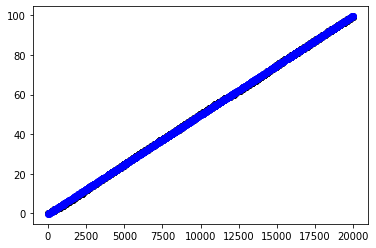

In [54]:
# Plot outputsst
plt.scatter(X_test, y_test,  color='black')
plt.scatter(X_test, y_pred, color='blue')
#plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.show()